In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MNIST

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. If we need to avoid this, we use `as_frame=False`.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)  
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

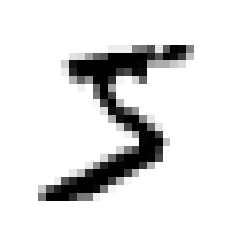

In [5]:
%matplotlib inline
import matplotlib as mpl

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

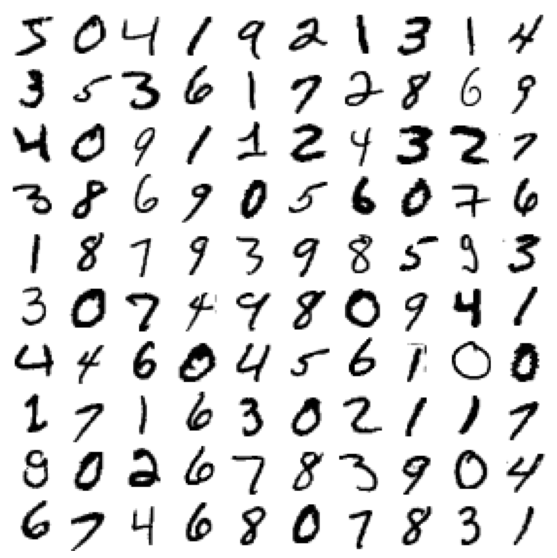

In [10]:
plt.figure(figsize=(10,10))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [12]:
n, m = X.shape

In [13]:
X_train = X_train / 255

In [14]:
y_train.shape

(52500,)

# The Neural Network

This neural net has one hidden layer with 20 nodes.

## Forward and Back Propagation

In [52]:
# parameters initialization
def init_params():
    W1 = 0.05 * np.random.rand(16, 784) 
    b1 = 0.05* np.random.rand(16, 1) 
    W2 = 0.25 * np.random.rand(10, 16) 
    b2 = 0.25 * np.random.rand(10, 1) 
    return W1, b1, W2, b2

In [53]:
#ReLU
def ReLU(Z):
    return np.maximum(0,Z)

#sigmoid
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

#softmax
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

#DReLU (derivative of the ReLU function)
def DReLU(Z):
    return Z > 0

#Dsigmoid (derivative of the sigmoid function)
def Dsigmoid(Z):   
    return sigmoid(Z)*(1 - sigmoid(Z))

In [54]:
#forward propagation
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [55]:
#one_hot the output
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y      
    

In [56]:
#back propagation
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * DReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

In [57]:
#update parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

## Gradient Descent

In [58]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [62]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
    
    return W1, b1, W2, b2

In [63]:
import warnings
warnings.filterwarnings('ignore')

W1, b1, W2, b2 = gradient_descent(X_train.T, y_train.T, 0.1, 50)

In [64]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train.T[:, index, None]
    prediction = make_predictions(X_test.T[:, index, None], W1, b1, W2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  0


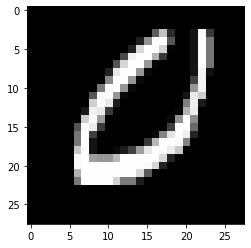

Prediction:  [0]
Label:  3


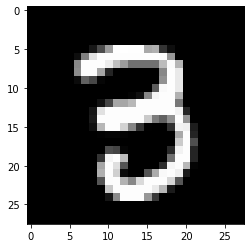

Prediction:  [0]
Label:  3


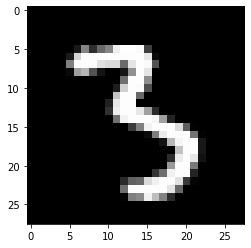

Prediction:  [0]
Label:  3


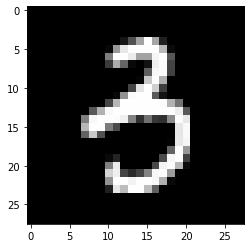

In [65]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [66]:
train_predictions = make_predictions(X_train.T, W1, b1, W2, b2)
get_accuracy(train_predictions, y_train)

[0 3 3 ... 9 2 7] [0 3 3 ... 9 2 7]


0.7524

In [67]:
test_predictions = make_predictions(X_test.T, W1, b1, W2, b2)
get_accuracy(test_predictions, y_test)

[0 0 0 ... 2 0 0] [3 6 4 ... 5 7 2]


0.21217142857142857

Although training accuracy was high ~ 85%, low testing accuracy ~ 64% clearly indicating overfitting. 

# Using Scikit-Learn

In [47]:
from sklearn.neural_network import MLPClassifier

In [48]:
mlp = MLPClassifier(hidden_layer_sizes=(50, ), max_iter=20, alpha=1e-4, solver='sgd', verbose=True, random_state=42, learning_rate_init=0.1)

In [49]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.33401605
Iteration 2, loss = 0.15235860
Iteration 3, loss = 0.11302095
Iteration 4, loss = 0.08994587
Iteration 5, loss = 0.07656302
Iteration 6, loss = 0.06615939
Iteration 7, loss = 0.05862779
Iteration 8, loss = 0.05084891
Iteration 9, loss = 0.04655720
Iteration 10, loss = 0.04087537
Iteration 11, loss = 0.03685217
Iteration 12, loss = 0.03253318
Iteration 13, loss = 0.02940071
Iteration 14, loss = 0.02644525
Iteration 15, loss = 0.02243470
Iteration 16, loss = 0.02115621
Iteration 17, loss = 0.01830672
Iteration 18, loss = 0.01657563
Iteration 19, loss = 0.01492009
Iteration 20, loss = 0.01330293


MLPClassifier(hidden_layer_sizes=(50,), learning_rate_init=0.1, max_iter=20,
              random_state=42, solver='sgd', verbose=True)

In [50]:
print(f"Training set score: {mlp.score(X_train, y_train):.3f}")
print(f"Test set score: {mlp.score(X_test, y_test):.3f}")

Training set score: 0.997
Test set score: 0.963


Really good training and testing accuracy. Much better than our `primitive gradient descent model`.  

In [35]:
mlp1 = MLPClassifier(hidden_layer_sizes=(16, ), max_iter=20, alpha=1e-4, verbose=True, random_state=42, learning_rate_init=0.1)

In [36]:
mlp1.fit(X_train, y_train)

Iteration 1, loss = 0.61412670
Iteration 2, loss = 0.46412177
Iteration 3, loss = 0.46159844
Iteration 4, loss = 0.45428735
Iteration 5, loss = 0.46533673
Iteration 6, loss = 0.42774811
Iteration 7, loss = 0.46669201
Iteration 8, loss = 0.45006522
Iteration 9, loss = 0.46729627
Iteration 10, loss = 0.49993111
Iteration 11, loss = 0.51343577
Iteration 12, loss = 0.48692034
Iteration 13, loss = 0.47745480
Iteration 14, loss = 0.46134134
Iteration 15, loss = 0.49045257
Iteration 16, loss = 0.47016800
Iteration 17, loss = 0.49600658
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=(16,), learning_rate_init=0.1, max_iter=20,
              random_state=42, verbose=True)

In [37]:
print(f"Training set score: {mlp1.score(X_train, y_train):.3f}")
print(f"Test set score: {mlp1.score(X_test, y_test):.3f}")

Training set score: 0.890
Test set score: 0.867


Using 16 neurons in the hiddden layer gave similar training accuracy but much better testing accuracy than our `primitive gradient descent model`.